In [1]:
import numpy as np
import src.graphinglib as gl
import scipy as sp
from scipy.signal import convolve, deconvolve
from astropy.modeling import models

from src.hdu.cubes.cube import Cube
from src.spectrums.spectrum import Spectrum

In [2]:
calib = Cube.load("data/orion/calibration/calibration_cube.fits")
nii_cube = Cube.load("data/orion/data_cubes/nii_1.fits")

calib_spec = calib[:,250,250]
nii_spec = nii_cube[:,250,250]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]


### Early tests

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


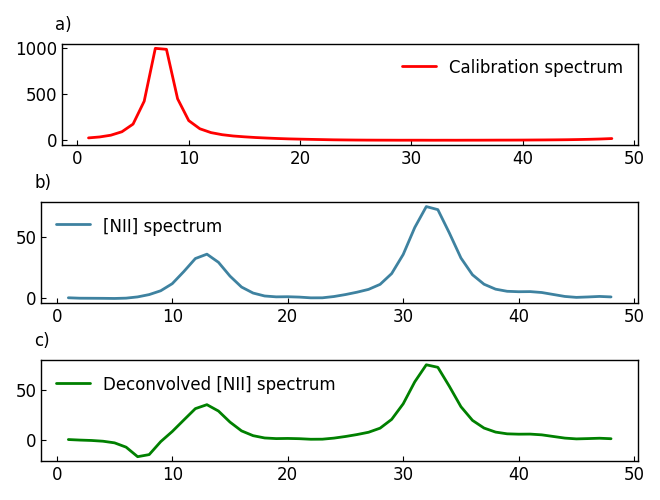

In [ ]:
deconvolved_spec = deconvolve(nii_spec.data, calib_spec.data)[1]

deconvolution_fig = gl.SmartFigure(3, 1, elements=[calib_spec.plot, nii_spec.plot,
                                     gl.Curve(nii_spec.x_values, deconvolved_spec, label="Deconvolved [NII] spectrum")])
deconvolution_fig[0][0].label = "Calibration spectrum"
deconvolution_fig[0][0].color = "red"
deconvolution_fig[1][0].label = "[NII] spectrum"
deconvolution_fig[2][0].color = "green"
deconvolution_fig.show()

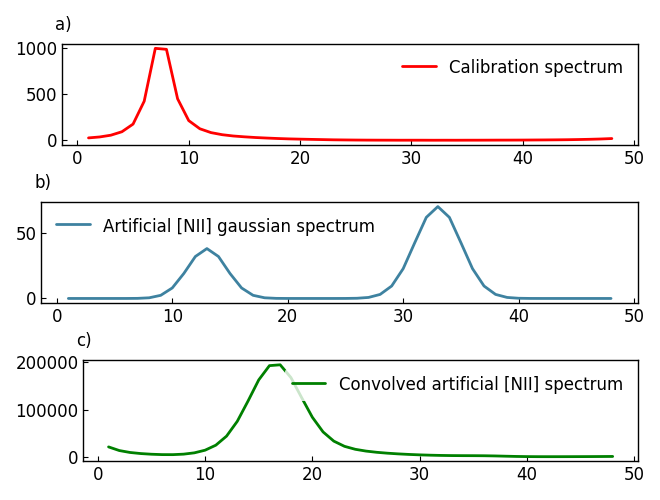

In [72]:
fake_nii_spec = Spectrum((models.Gaussian1D(38, 13, 1.7) + models.Gaussian1D(70, 33, 2))(nii_spec.x_values), None)
convoluted_spec = convolve(fake_nii_spec.data, calib_spec.data, mode="same")

convolution_fig = gl.SmartFigure(3, 1, elements=[plot := calib_spec.plot, fake_nii_spec.plot,
                            gl.Curve(nii_spec.x_values, convoluted_spec, label="Convolved artificial [NII] spectrum")])
plot.label = "Calibration spectrum"
plot.color = "red"
convolution_fig[1][0].label = "Artificial [NII] gaussian spectrum"
convolution_fig[2][0].color = "green"
convolution_fig.show()

### New tests

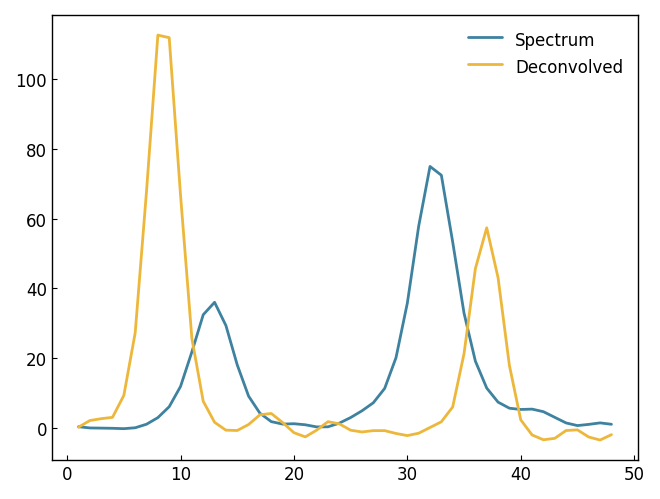

In [17]:
resampled_calib = sp.signal.resample(calib_spec.data, nii_spec.data.size)
# gl.SmartFigure(elements=[gl.Curve(np.arange(48) + 1, resampled_calib), gl.Curve(np.linspace(1, 48, 192), calib_spec.data)]).show()
normalized_calib = resampled_calib / np.sum(resampled_calib)
normalized_calib = np.roll(normalized_calib, nii_spec.data.size // 2 - np.argmax(normalized_calib))
# gl.SmartFigure(elements=[gl.Curve(np.arange(48) + 1, normalized_calib)]).show()

def wiener_deconvolve(signal, kernel, K=0.01):
    S = np.fft.fft(signal)
    H = np.fft.fft(kernel)
    H_conj = np.conj(H)
    return np.real(np.fft.ifft((H_conj / (H_conj * H + K)) * S))

n = 2 * len(nii_spec.data)  # Or next power of 2 for efficiency
signal = np.pad(nii_spec.data, (0, n - len(nii_spec.data)))
kernel = np.pad(normalized_calib, (0, n - len(normalized_calib)))
deconvolved_spec = wiener_deconvolve(signal, kernel)
deconvolved_spec = wiener_deconvolve(nii_spec.data, normalized_calib)
deconvolved_curve = gl.Curve(np.arange(nii_spec.data.size) + 1, deconvolved_spec, label="Deconvolved")
g_spec = gl.FitFromGaussian(nii_spec.plot, "Spectrum fit", [75, 32, 5])
g_deconv = gl.FitFromGaussian(deconvolved_curve, "Deconvolved fit", [115, 25, 5])
gl.SmartFigure(elements=[nii_spec.plot, deconvolved_curve]).show()
# gl.SmartFigure(elements=[nii_spec.plot, deconvolved_curve, g_spec, g_deconv]).show()

### Test convolution

/var/folders/z8/44crt9313mlc559ypygm9ptw0000gn/T/ipykernel_99062/2971605551.py:11: DeprecationWarning: dtype=>f4 is not supported by correlate and will raise an error in SciPy 1.17.0. Supported dtypes are: boolean, integer, `np.float16`,`np.float32`, `np.float64`, `np.complex64`, `np.complex128`.
  convolved_compound = convolve(compound_spec.data, calib_spec.data, mode="same")


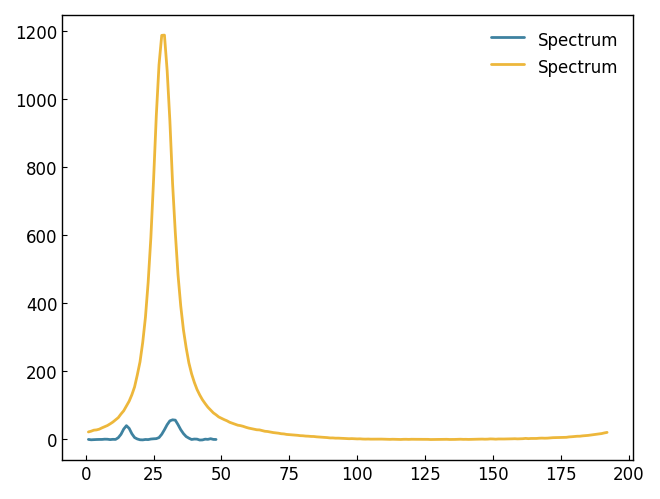

In [3]:
# Create a compound spectrum: two Gaussians + noise
x = nii_spec.x_values
gauss1 = models.Gaussian1D(amplitude=40, mean=15, stddev=1.5)
gauss2 = models.Gaussian1D(amplitude=60, mean=32, stddev=2.5)
noise = np.random.normal(0, 1, size=x.size)
compound_data = gauss1(x) + gauss2(x) + noise

compound_spec = Spectrum(compound_data, None)

# Convolve with calib_spec
convolved_compound = convolve(compound_spec.data, calib_spec.data, mode="same")

# Plot the result
gl.SmartFigure(elements=[
    compound_spec.plot,
    calib_spec.plot,
    # gl.Curve(x, convolved_compound, label="Convolved Compound Spectrum")
]).show()

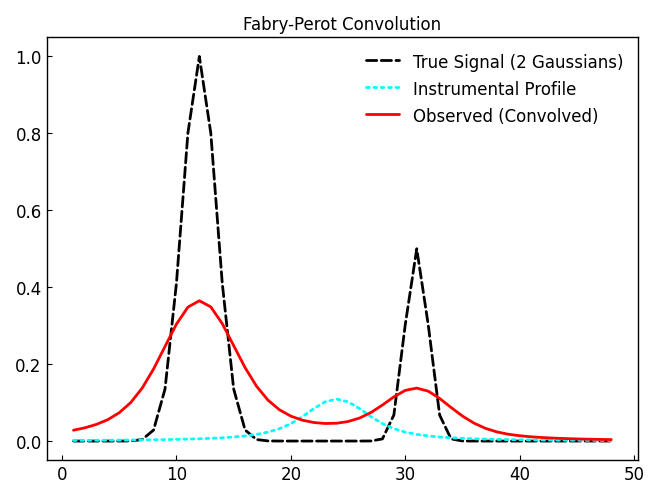

In [4]:
import numpy as np
import src.graphinglib as gl
from scipy.signal import fftconvolve
from scipy.special import voigt_profile

# --- Define channel axis ---
x = np.linspace(1, 48, 48)

# --- 1. TRUE SIGNAL: Two Gaussians ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

true_signal = (
    gaussian(x, amp=1.0, mu=12, sigma=1.5) +   # Main emission
    gaussian(x, amp=0.5, mu=31, sigma=1.0)     # Companion line
)

# --- 2. INSTRUMENTAL FUNCTION (approximated Gaussian) ---
instrumental_sigma = 2.5
# instrumental_kernel = gaussian(x, 1.0, mu=24, sigma=instrumental_sigma)
instrumental_kernel = voigt_profile(x - 24, 1.5, instrumental_sigma)
instrumental_kernel /= np.sum(instrumental_kernel)  # Normalize

# --- 3. Convolve (observed spectrum) ---
observed_signal = fftconvolve(true_signal, instrumental_kernel, mode='same')

# --- 4. Wrap into graphinglib Curves ---
true_curve = gl.Curve(x, true_signal, label="True Signal (2 Gaussians)", color="black", line_style="--")
instr_curve = gl.Curve(x, instrumental_kernel * true_signal.max(), label="Instrumental Profile", color="cyan", line_style=":")
observed_curve = gl.Curve(x, observed_signal, label="Observed (Convolved)", color="red")


g_fit = gl.FitFromGaussian(observed_curve, "Observed Fit", [0.15, 31, 4], color="lime")

# --- 5. Plot ---
sf = gl.SmartFigure(
    elements=[true_curve, instr_curve, observed_curve],#, g_fit],
    title="Fabry-Perot Convolution",
).show()

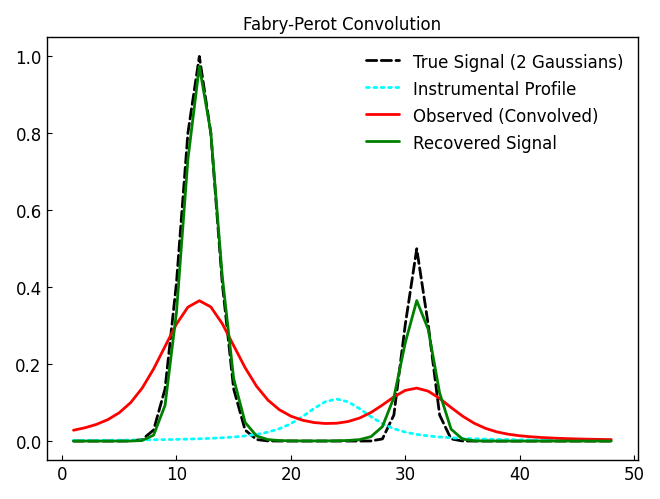

In [6]:
from skimage.restoration import richardson_lucy

# Ensure normalization of kernel
kernel = instrumental_kernel / np.sum(instrumental_kernel)
recovered_signal = richardson_lucy(observed_signal, kernel, num_iter=70)

rec_curve = gl.Curve(x, recovered_signal, label="Recovered Signal", color="green")

sf.copy().add_elements(rec_curve).show()